In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import graphviz
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report


%run utility_functions.py # functions reused throughout

0    16258
1     1639
Name: 0, dtype: int64

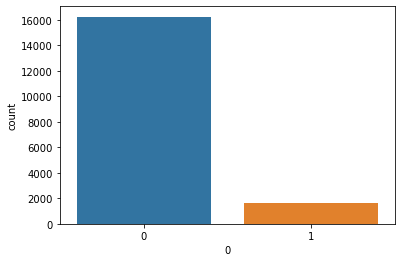

In [2]:
# Dataset source:
# http://archive.ics.uci.edu/ml/datasets/HTRU2#

# Read in data
data = pd.read_csv('../data/HTRU2/HTRU_2.csv', sep=',')

sns.countplot(data.iloc[:,-1]) # plot number of things with each value

data.iloc[:,-1].value_counts(sort=True)
# skewed toward predicting negative

In [3]:
# Create training, testing, and validation sets

X = data.drop(data.columns[-1], axis=1) # last value is the pulsar indicator

y = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2) # 80/20 default

# scale so it converges
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train = scaling.transform(x_train)
x_test = scaling.transform(x_test)

In [4]:

# default 'adam'
clf = MLPClassifier(random_state=0, early_stopping=True)

parameters = {'hidden_layer_sizes': np.arange(1, 6),
              'alpha': 10.0 ** -np.arange(1, 10),
              'max_iter': 100 * np.arange(3, 5),
              'n_iter_no_change': [10, 20, 30, 40],
              'learning_rate': ['constant', 'adaptive', 'invscaling']
             }

# filter warnings

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Scorer for parameter combinations
acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, cv=5, n_jobs=4)
grid_obj = grid_obj.fit(x_train, y_train)

# Set clf to best combination of parameters
clf = grid_obj.best_estimator_

In [5]:
# train model
clf.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=2, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=30, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

No Skill: ROC AUC=0.500
Model: ROC AUC=0.945


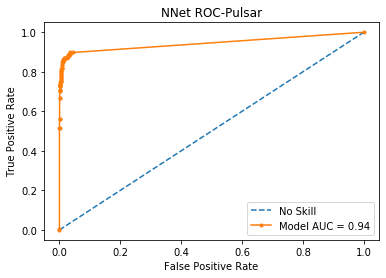

Model: f1=0.870 auc=0.913


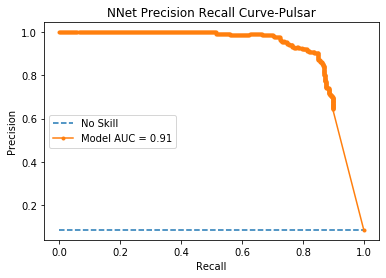

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3277
           1       0.89      0.85      0.87       303

    accuracy                           0.98      3580
   macro avg       0.94      0.92      0.93      3580
weighted avg       0.98      0.98      0.98      3580

Confusion Matrix
[[3246   31]
 [  46  257]]
Accuracy
0.9784916201117319
Balanced Accuracy
0.9193624733239268


<module 'matplotlib.pyplot' from 'c:\\users\\spcbe\\miniconda3\\envs\\ml_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

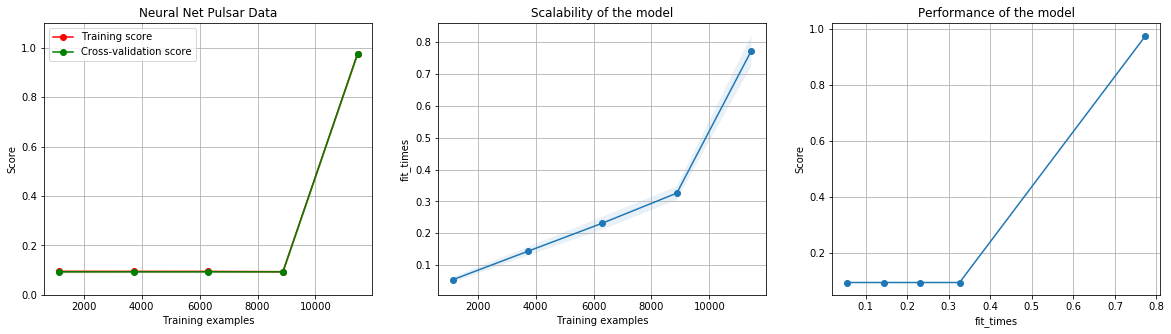

In [6]:
# test
y_predict = clf.predict(x_test)

# ROC
plot_roc(clf, x_test, y_test, y_predict, 'NNet ROC-Pulsar')
# Recall_precision_curve
plot_precision_recall_curve(clf, x_test, y_test, y_predict, 'NNet Precision Recall Curve-Pulsar')


# how did we do? Comparing y_test and predicted values
print('Classification Report')
print(classification_report(y_test, y_predict,zero_division=1))
print('Confusion Matrix')
# how to interpret: https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
print(confusion_matrix(y_test, y_predict))
print('Accuracy')
print(accuracy_score(y_test, y_predict))

# for unbalanced data
print('Balanced Accuracy')
print(balanced_accuracy_score(y_test, y_predict))

# 1.1 so I can see the top of the plot
plot_learning_curve(clf, "Neural Net Pulsar Data", x_train, y_train, ylim=[0,1.1])

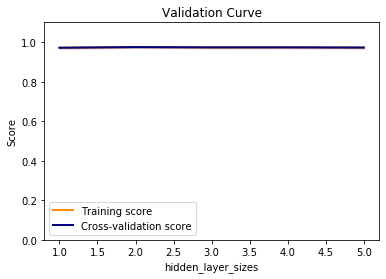

In [7]:
plot_model_complexity_analysis(clf, 'hidden_layer_sizes', np.arange(1, 6), 'NNet_pulsar',
                               x_train, y_train)

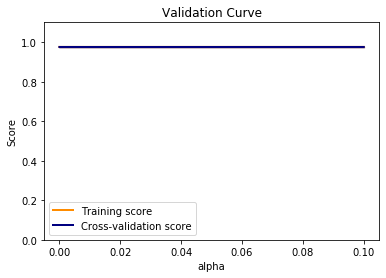

In [8]:
plot_model_complexity_analysis(clf, 'alpha', 10.0 ** -np.arange(1, 10), 'NNet_pulsar', x_train, y_train)

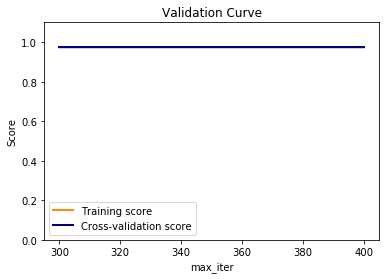

In [9]:
plot_model_complexity_analysis(clf, 'max_iter', 100 * np.arange(3, 5), 'NNet_pulsar', x_train, y_train)

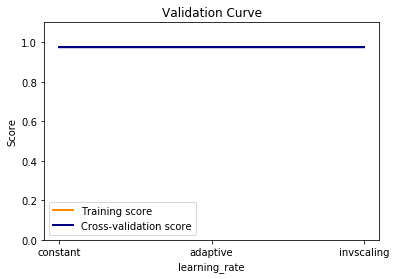

In [10]:
plot_model_complexity_analysis(clf, 'learning_rate', ['constant', 'adaptive', 'invscaling'], 'NNet_pulsar', x_train, y_train)